In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import hdbscan
import time
from tabulate import tabulate
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, silhouette_score
import sys
sys.path.append("T:/laupodteam/AIOS/Chontira/CellDynClustering")
from evaluation.fast_dunn_index import dunn_fast
%matplotlib inline


## Loading of data

In [2]:
dm6 = pd.read_feather('L:\lab_research\RES-Folder-UPOD\Celldynclustering\E_ResearchData\\2_ResearchData\embedded_celldyn_nn50_ndim6.feather')
dm6.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6
0,9.613940,3.153382,4.224900,9.465697,9.768558,3.645482
1,9.589159,3.769300,5.196580,8.247450,9.962569,3.524544
2,9.547850,3.112157,4.268517,9.238219,9.481384,3.351720
3,10.264716,3.385825,6.014765,7.139993,7.896206,3.038558
4,10.607414,3.627557,3.979383,9.528340,10.479579,4.097281


## Various functions for building of clusters

In [3]:
def multiple_line_plots(data, x):
    
    """
    Plot multiple line plots for a particular X variable.
    
    Parameters
    ---------
    data: dataframe
            data (including x variable) for plotting.
    
    x: String
            name of the X variable to be plotted.
                
    """
    
    df_shape = data.shape
    y_vars=data.loc[:, data.columns != x].columns
    for y in y_vars:
        plot = sns.lineplot(x=data[x], y = data[y])
        plt.show()
        

def metrics_scores(x, labels, *args ,verbose=False):
    """
    Calculates scores for clusters assignment using different metrics (args). 
    
    Parameters
    ---------
    x: dataframe
        data entries for calculating the scores.
    
    labels: list of integers
        cluster labels.
    
    *args: arguments
        further arguments to include the metrics (as function statement)
        if the functions take x and labels as argument.
        
    verbose: bool, optional
        whether to print the results.
    
    
    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    
    """
    
    results = {}
    for a in args:
        results.update({a.__name__ : a(x, labels)})
    
    if(verbose):
        print_metric_scores(results)
    
    return results
    

def print_metric_scores(results):
    
    """
    Print mertic scores in a table format.
    
    Parameters
    ---------
    results: dict
            dictionary of results to be printed in a table format. 
    
    """
    
    tab = []
    
    for metric, score in results.items():
        tab.append([metric, score])
    
    print(tabulate(tab, headers = ["Metric","Score"]))
    print("\n")
    


def fit_predict_X(x,*args, **kwargs):
    """
    Feed in most models as a parameter as *args and its parameters as **kwargs.
    Useful for wanting to paramter tuning the model.

    Parameter
    --------
    
    x: dataframe
            the data to be fitted to the model.

    *args: function (model)
            the model as function to train the dataset.
    
    **kwargs: paramters (for the model)
            the model paramters. 
        
    Return
    --------

    labels: list
            the predicted labels from the model.


    """
    model = args[0](**kwargs)
    print(model)
    labels = model.fit_predict(x)
    
    return labels

plt.style.use("seaborn-paper")

def plot_multi_scatter(data, row, col, subsample = 10000):
    plot_df = data.sample(subsample)

    fig, ax = plt.subplots(row,col,figsize = (30,50))
    i,j = 0,0

    for colx in plot_df:
        for coly in plot_df:
            ax[i,j].scatter(plot_df[colx],plot_df[coly], s = 3, alpha = 0.2)
            i = i+1 if j == col-1 else i
            j = j+1 if j < col-1 else 0

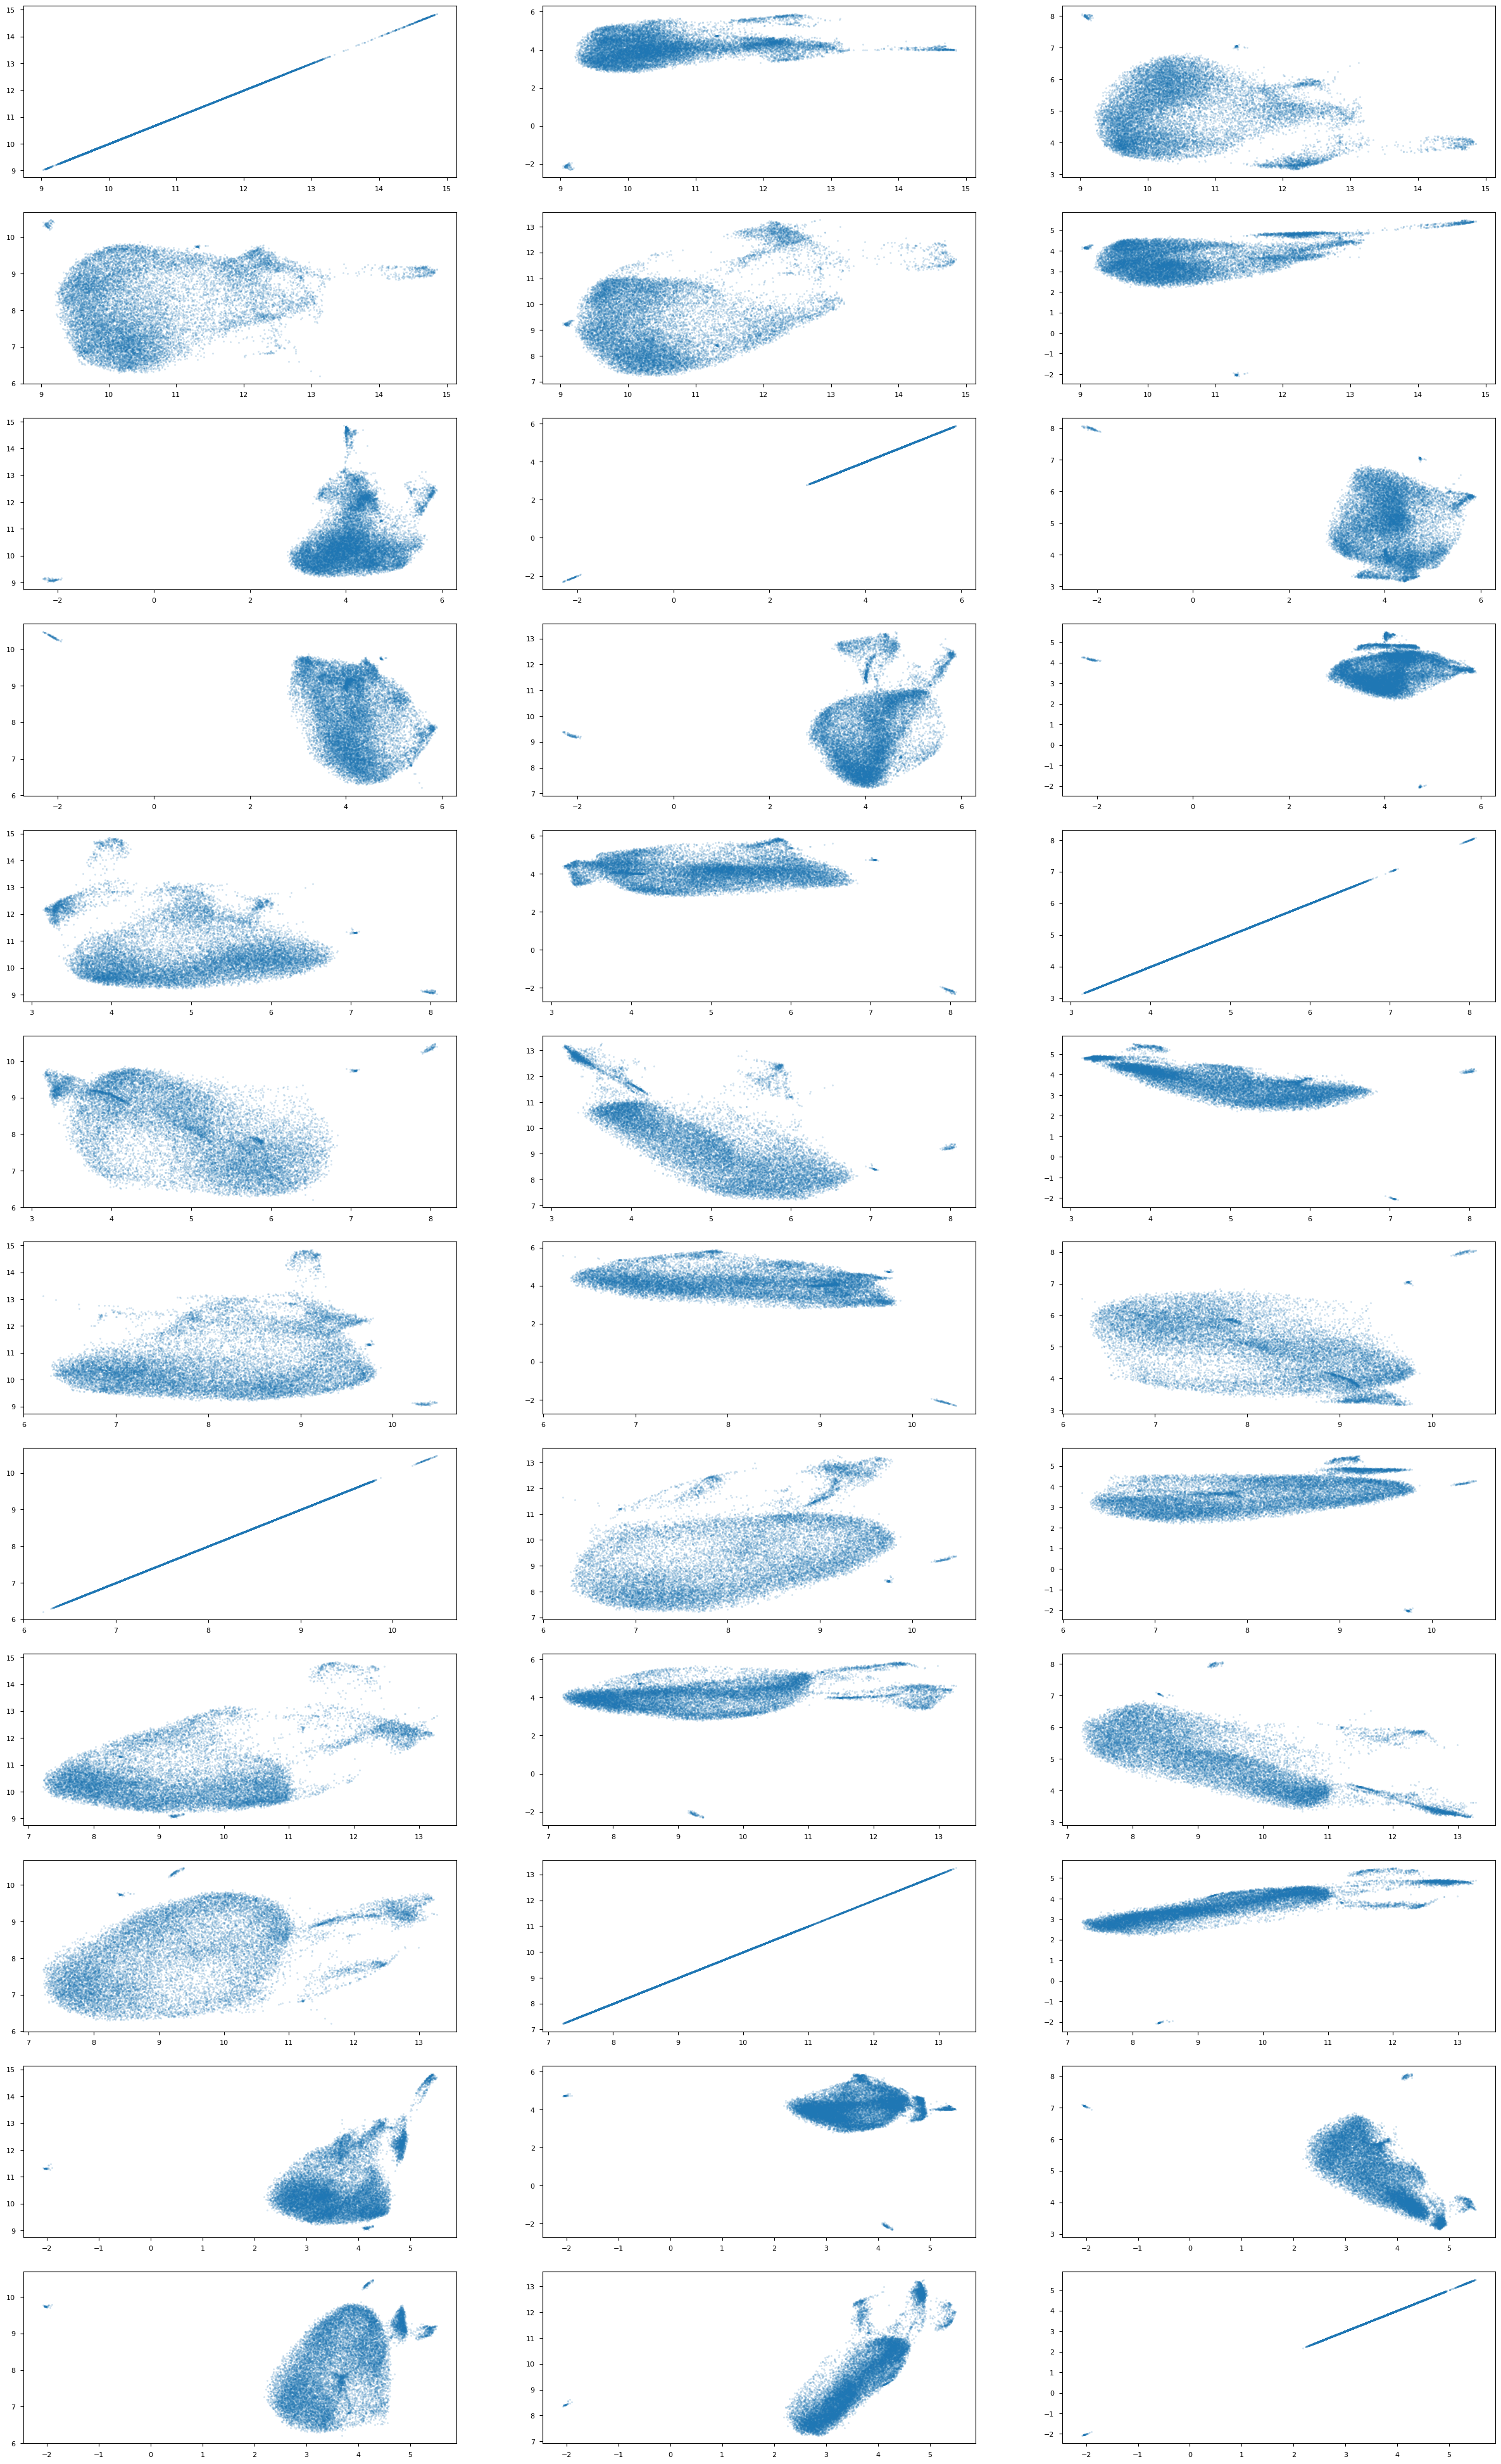

In [8]:
plot_multi_scatter(dm6, 12,3, 20000)

In [8]:
sub = dm6.sample(20000)
hdbscanner = hdbscan.HDBSCAN(gen_min_span_tree=False)
print(hdbscanner)
hdbscan_labels = hdbscanner.fit_predict(sub)
col_names = [ "silhouette_score", "davies_Bouldin", "dunn_index"]
results = metrics_scores(sub, hdbscan_labels,silhouette_score,davies_bouldin_score, dunn_fast,verbose=True)


HDBSCAN()
Metric                   Score
--------------------  --------
silhouette_score      0.540857
davies_bouldin_score  0.34815
dunn_fast             0.013139




In [11]:
sub = dm6.sample(20000)

hdbscan_labels = fit_predict_X(sub, KMeans, n_clusters=2, random_state=0, algorithm = "lloyd")
col_names = [ "silhouette_score", "davies_Bouldin", "dunn_index"]
results = metrics_scores(sub, hdbscan_labels,silhouette_score,davies_bouldin_score, dunn_fast,verbose=True)


KMeans(n_clusters=2, random_state=0)
Metric                     Score
--------------------  ----------
silhouette_score      0.36873
davies_bouldin_score  1.09951
dunn_fast             0.00941089




## Hyperparamter tuning

## Testing of various sub sampled data because the full dataset takes a long time

In [29]:
samples = [100, 1000, 2000, 5000, 10000, 20000, 30000, 50000]

avgs = []

for s in samples:
    
    sil_scores = []
    dunn_scores = []
    db_scores = []
    time_scores = []
    print(f"Tuning sample size of {s} starts")
    
    
    for j in range(10):
        
        sub = dm6.sample(s)
        start = time.time()
        
        hdbscanner = hdbscan.HDBSCAN()
        hdbscan_labels = hdbscanner.fit_predict(sub)
        
        
        sil_scores.append(silhouette_score(X = sub, labels = hdbscan_labels))
        dunn_scores.append(dunn_fast(sub, hdbscan_labels))
        db_scores.append(davies_bouldin_score(sub, hdbscan_labels))
        time_scores.append(time.time() - start)
    
    mean_time = np.mean(time_scores)
    mean_sil = np.mean(sil_scores)
    mean_dunn = np.mean(dunn_scores)
    mean_db = np.mean(db_scores)
    
    print(tabulate([['Silhouette', mean_sil], ['Davies-Bouldin', mean_db], ['Dunn index', mean_dunn], ['Time in second', mean_time] ], headers=['Metric', 'Score']))
    print("\n")
  
    
    avgs.append([s, mean_sil, mean_dunn, mean_db, mean_time])
    

Tuning sample size of 100 starts
Metric               Score
--------------  ----------
Silhouette      0.294674
Davies-Bouldin  1.44225
Dunn index      0.194611
Time in second  0.00738015


Tuning sample size of 1000 starts
Metric              Score
--------------  ---------
Silhouette      0.402518
Davies-Bouldin  1.26123
Dunn index      0.226138
Time in second  0.0700388


Tuning sample size of 2000 starts
Metric             Score
--------------  --------
Silhouette      0.44194
Davies-Bouldin  0.913595
Dunn index      0.456628
Time in second  0.188482


Tuning sample size of 5000 starts
Metric             Score
--------------  --------
Silhouette      0.485093
Davies-Bouldin  0.431796
Dunn index      0.578877
Time in second  1.04356


Tuning sample size of 10000 starts
Metric             Score
--------------  --------
Silhouette      0.550426
Davies-Bouldin  0.341974
Dunn index      0.628411
Time in second  4.66066


Tuning sample size of 20000 starts
Metric              Score
-----

In [36]:
col_names = ["sample_size", "silhouette_score", "davies_Bouldin", "dunn_index", "time_in_second"]
sample_size_scores = pd.DataFrame(avgs, 
                  columns = col_names)

sample_size_scores.to_csv("sample_size_scores.csv",index=False)

## To conclude, looks like 20000 is best for subsampling of cell-dyn dataset to use for HDBSCAN for now